In [1]:
import ast
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
%%capture

# Make sure to add project root directory to PYTHONPATH
# export PYTHONPATH="${PYTHONPATH}:${pwd}"

# Change directory to project root directory

%cd ..

In [3]:
dfbwoa = pd.read_csv("data/results/merged/balanced_woa.csv").reset_index(drop=True).drop(columns="Unnamed: 0")
expanded_hparams = pd.json_normalize(dfbwoa["fs_method_kwargs"].apply(ast.literal_eval))
dfbwoa = pd.concat([dfbwoa, expanded_hparams], axis=1).drop(columns=["fs_method_kwargs"])

min_max = (
    dfbwoa.groupby(["extractor", "vm", "target_col"])["score"]
    .agg(["min", "max", "mean", "std"])
    .reset_index()
)
dfbwoa = dfbwoa.merge(min_max, on=["extractor", "vm", "target_col"], how="left")

dfbwoa["nscore"] = (dfbwoa["score"] - dfbwoa["min"]) / (dfbwoa["max"] - dfbwoa["min"])
dfbwoa["nscore"] = dfbwoa["nscore"].fillna(1.0)

dfbwoa["zscore"] = (dfbwoa["score"] - dfbwoa["mean"]) / (dfbwoa["std"])
dfbwoa["zscore"] = dfbwoa["zscore"].fillna(3.0)

dfbwoa["selected_ratio"] = dfbwoa["n_selected_features"] / dfbwoa["num_features"]

dfbwoa.columns

Index(['fs_method', 'n_selected_features', 'score', 'time', 'data_dir',
       'extractor', 'vm', 'objective_fn', 'target_col', 'num_features',
       'timestamp', 'duration [s]', 'emissions_rate [kg/s]', 'cpu_power [W]',
       'ram_power [W]', 'cpu_energy [kWh]', 'ram_energy [kWh]',
       'energy_consumed [kWh]', 'steps', 'size', 'transition_fn',
       'temperature', 'scaler', 'activate_best_if_empty',
       'use_vector_correction', 'population_init_method', 'min', 'max', 'mean',
       'std', 'nscore', 'zscore', 'selected_ratio'],
      dtype='object')

In [4]:
techniques = [
    "transition_fn",
    "temperature",
    "scaler",
    "activate_best_if_empty",
    "use_vector_correction",
    "population_init_method",
]


def custom_agg(x):
    return pd.Series(
        {
            "mean": x.mean(),
            "std": x.std(),
            "IQR": x.quantile(0.75) - x.quantile(0.25),
        }
    )


for tech in techniques:
    print(f"\nAggregation by: {tech}")
    df_agg = dfbwoa.groupby(tech)[
        ["score", "nscore", "time", "selected_ratio", "energy_consumed [kWh]"]
    ].apply(lambda g: g.aggregate(custom_agg))
    df_agg = df_agg.stack(level=0).unstack(level=(1, 2))
    df_agg.columns = [f"{metric}_{col}" for col, metric in df_agg.columns]
    df_agg = df_agg.sort_index(axis=1)
    display(df_agg)


Aggregation by: transition_fn


,energy_consumed [kWh]_IQR,energy_consumed [kWh]_mean,energy_consumed [kWh]_std,nscore_IQR,nscore_mean,nscore_std,score_IQR,score_mean,score_std,selected_ratio_IQR,selected_ratio_mean,selected_ratio_std,time_IQR,time_mean,time_std
transition_fn,,,,,,,,,,,,,,,
sigmoid_transition_fn,0.007540,0.007475,0.009347,0.459220,0.405469,0.271035,3.149100,3.224492,2.509482,0.162393,0.330080,0.144660,270.411643,268.061371,335.190825
tanh_transition_fn,0.007389,0.007227,0.009001,0.451233,0.363213,0.265463,3.135638,3.167105,2.481918,0.189574,0.316984,0.172004,264.998176,259.164815,322.792994



Aggregation by: temperature


,energy_consumed [kWh]_IQR,energy_consumed [kWh]_mean,energy_consumed [kWh]_std,nscore_IQR,nscore_mean,nscore_std,score_IQR,score_mean,score_std,selected_ratio_IQR,selected_ratio_mean,selected_ratio_std,time_IQR,time_mean,time_std
temperature,,,,,,,,,,,,,,,
ConstTemperature,0.008895,0.008870,0.011393,0.479537,0.385914,0.275289,3.153907,3.188605,2.504991,0.179792,0.521308,0.157561,318.994470,318.084944,408.581633
LinearTemperatureDecay,0.007526,0.007105,0.008621,0.454682,0.384667,0.265044,3.136753,3.199894,2.491009,0.115620,0.266058,0.092881,269.898429,254.778858,309.152675
PowerTemperatureDecay,0.006928,0.006338,0.007445,0.457755,0.385462,0.268594,3.135286,3.197268,2.490573,0.094017,0.251219,0.087307,248.446174,227.289878,266.991748
SigmoidTemperatureDecay,0.007528,0.007094,0.008599,0.456540,0.381808,0.267503,3.135491,3.198092,2.498379,0.111111,0.255634,0.088039,269.953091,254.381947,308.368248



Aggregation by: scaler


,energy_consumed [kWh]_IQR,energy_consumed [kWh]_mean,energy_consumed [kWh]_std,nscore_IQR,nscore_mean,nscore_std,score_IQR,score_mean,score_std,selected_ratio_IQR,selected_ratio_mean,selected_ratio_std,time_IQR,time_mean,time_std
scaler,,,,,,,,,,,,,,,
GlobalZScoreScaler,0.006985,0.006797,0.008160,0.448285,0.374326,0.265051,3.131271,3.189701,2.490490,0.160780,0.289513,0.134031,250.504008,243.763510,292.621869
LocalZScoreScaler,0.007063,0.006944,0.008415,0.437290,0.360551,0.259454,3.139044,3.183672,2.482296,0.178571,0.301077,0.122900,253.302791,249.030350,301.760024
PassTroughScaler,0.008707,0.008891,0.011417,0.473100,0.432731,0.280145,3.150484,3.224071,2.525801,0.253663,0.417790,0.196626,312.269815,318.829198,409.441036
ProgressiveZScoreScaler,0.006909,0.006772,0.008123,0.450727,0.370189,0.265473,3.142021,3.186378,2.485917,0.163645,0.285744,0.131833,247.754609,242.844783,291.286860



Aggregation by: activate_best_if_empty


,energy_consumed [kWh]_IQR,energy_consumed [kWh]_mean,energy_consumed [kWh]_std,nscore_IQR,nscore_mean,nscore_std,score_IQR,score_mean,score_std,selected_ratio_IQR,selected_ratio_mean,selected_ratio_std,time_IQR,time_mean,time_std
activate_best_if_empty,,,,,,,,,,,,,,,
False,0.007497,0.007393,0.009263,0.461373,0.382255,0.269459,3.140566,3.196315,2.492126,0.178571,0.323682,0.159103,268.855317,265.115327,332.190812
True,0.007497,0.007310,0.009091,0.461297,0.386675,0.268742,3.142349,3.195613,2.499841,0.178571,0.323458,0.158851,268.865994,262.159078,325.999150



Aggregation by: use_vector_correction


,energy_consumed [kWh]_IQR,energy_consumed [kWh]_mean,energy_consumed [kWh]_std,nscore_IQR,nscore_mean,nscore_std,score_IQR,score_mean,score_std,selected_ratio_IQR,selected_ratio_mean,selected_ratio_std,time_IQR,time_mean,time_std
use_vector_correction,,,,,,,,,,,,,,,
False,0.007538,0.007544,0.009530,0.458883,0.38327,0.268282,3.149740,3.215649,2.504166,0.178571,0.324025,0.159740,270.328204,270.523899,341.747946
True,0.007121,0.007157,0.008803,0.465037,0.38567,0.269941,3.138138,3.176051,2.487518,0.178571,0.323109,0.158201,255.360184,256.673677,315.671173



Aggregation by: population_init_method


,energy_consumed [kWh]_IQR,energy_consumed [kWh]_mean,energy_consumed [kWh]_std,nscore_IQR,nscore_mean,nscore_std,score_IQR,score_mean,score_std,selected_ratio_IQR,selected_ratio_mean,selected_ratio_std,time_IQR,time_mean,time_std
population_init_method,,,,,,,,,,,,,,,
random,0.007542,0.007632,0.009716,0.461305,0.385544,0.269494,3.152178,3.222502,2.504712,0.178571,0.324241,0.158766,270.482234,273.694673,348.418705
sobol,0.007018,0.007067,0.008587,0.464491,0.383365,0.268715,3.134205,3.169003,2.486792,0.178571,0.322887,0.159188,251.686171,253.422451,307.934175


In [5]:
dfbwoa.query("use_vector_correction == True")["nscore"].mean() - dfbwoa.query("use_vector_correction == False")["nscore"].mean()

np.float64(0.002399723174706825)

In [6]:
import seaborn as sn
import matplotlib.pyplot as plt

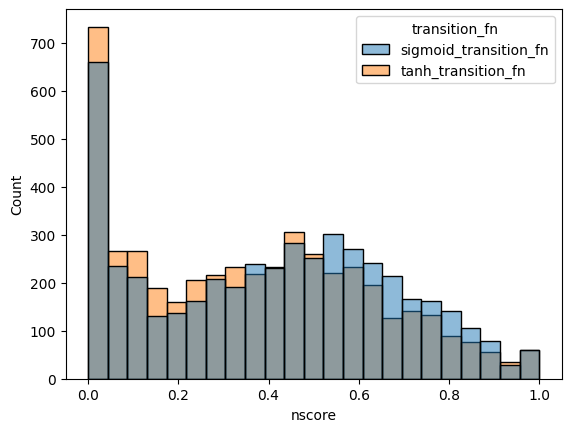

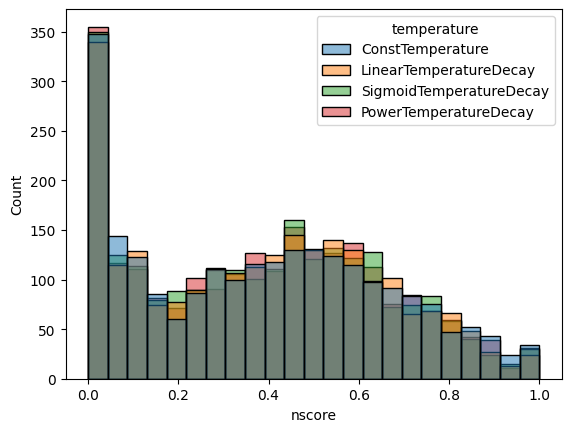

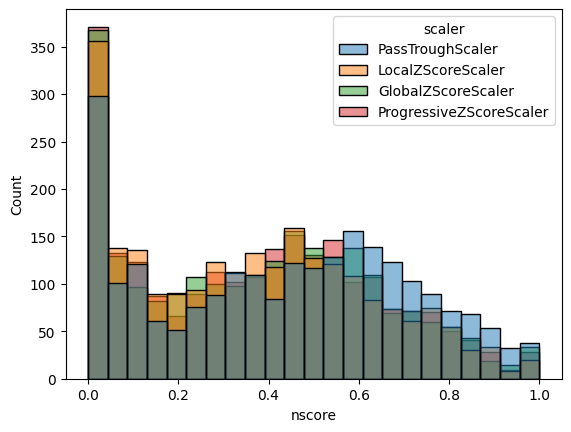

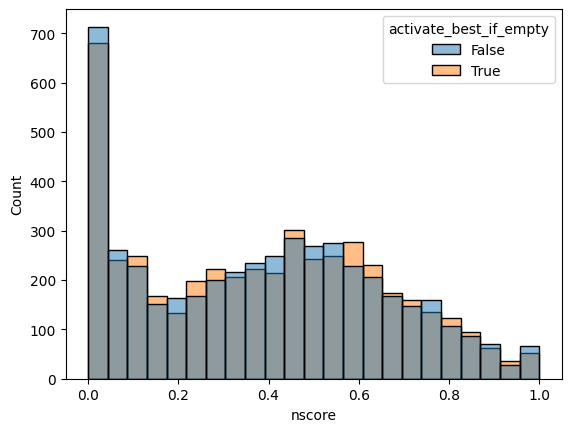

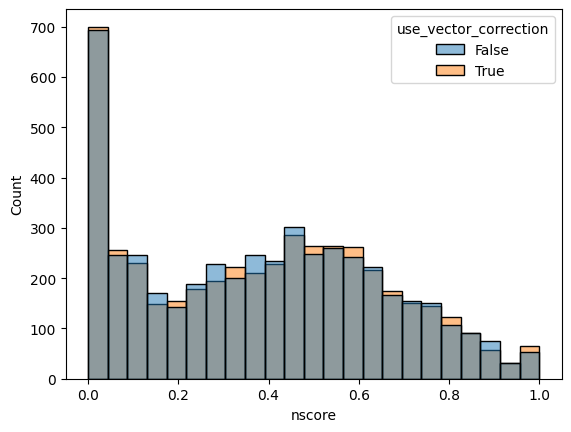

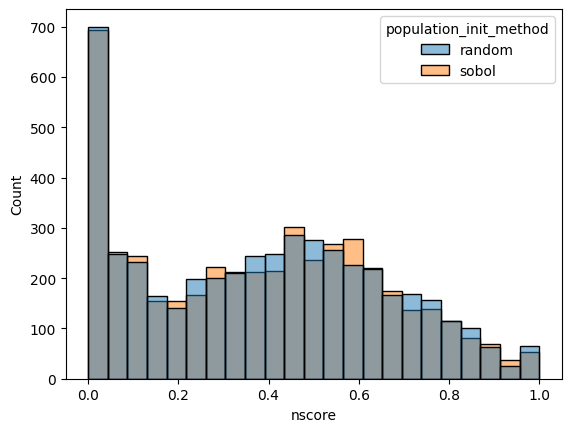

In [7]:
for t in techniques:
    sn.histplot(dfbwoa, x="nscore", hue=t)
    plt.show()